***
### __Darius Petermann__ <br>
Email: dariusarthur.petermann01@estudiant.upf.edu <br>
Project Git Page: https://github.com/darius522/satb-voice-estimate.git
#### Companion Code for the Paper: <br>  
*__"Source Number Estimation for monoaural SATB choral recordings"__*
***

How this notebook works:

This notebook is divided into three main sections:
* 1. [Data Handling Methodology](#part1): First we go through the generic set-up steps such as data handling, formatting, pre-processing:
    1. [Dataset Download](#part11):
    2. [Storing our Data in a Convenient Format](#part12)
    3. [Defining the Generator Function](#part13)
    4. [Computing Time-Domain Snippets](#part14)
* 2. [Baseline Computation](#part2): MFC's: We then dive into the first part of our experiment, which is the computation of our baseline using MFC's:
    1. [Feature Extraction](#part21)
    2. [Data Plotting](#part22)
    3. [Data Formatting](#part23)
    4. [Model Training / Testing](#part24)
    5. [Results](#part25)
* 3. [Deep Salience Approach](#part3): In the second part of our experiment, we use the deep salience framework (cited later), in order to improve upon our initial baseline:
    1. [Importing Required Python File - Defining Function Parameters](#part31)
    2. [Predicting Salience](#part32)
    3. [Results](#part33)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# We opt to define all the global configuration settings through this dict
config = {"resampling_fs" : 22050, #expected resampling rate on HDF5 file creation
          "dst_path":"./choral_dst", # User Dataset path (if None, the default one will be used)
          "hdf5_filepath":"./choral_dst.hdf5",
          "batch_size_train": 8192,
          "batch_size_test": 256,
          "num_frames": 22050 # 8 sec @ 22050Hz
         }

if not os.path.isdir('./debug'):
    os.mkdir('./debug')

<a id='part1'></a>
<h1><center>Data Handling Methodology</center></h1>

For the first step of this task, we will work from the __Choral Singing Dataset__, which contains three choir songs composed of 4 groups of 4 singers (16 parts per song), for a total of 48 stems. The dataset can be downloaded from Zenodo at the following:

https://zenodo.org/record/2649950#.XlJRNy2ZPRY

If you happen to already have the dataset locally, please define it's local path through the ***dst_path*** variable. Otherwise, the cell below will take care of downloading it for you:
***
<a id='part11'></a>
### 1. Dataset Download:

In [3]:
#This cell downloads the Mridangam Stroke Dataset in its entirety
import urllib.request
import zipfile
import os, sys,shutil

#Link for the dataset. If you already have the dataset locally, define its location through the config dict above 
url = 'https://zenodo.org/record/2649950/files/ChoralSingingDataset.zip'

if config["dst_path"] == None:
    main_data_dir = './choral_dst'
    if not os.path.exists(main_data_dir): #creating the directory if not exist
        os.mkdir(main_data_dir)
    print('Downloading Choral Singing Dataset Dataset...')
    foldername = url.split('/')[-1]
    urllib.request.urlretrieve(url,foldername)
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(foldername, 'r')
    zip_ref.extractall(main_data_dir)
    zip_ref.close()
    os.remove(foldername)#Removing the zip file
    print('Data downloaded and unzipped to: ',main_data_dir)
else:
    print('User Path Defined. Dataset Expected to be Found at the Following:\n'+config["dst_path"])
 

User Path Defined. Dataset Expected to be Found at the Following:
./choral_dst


<a id='part12'></a>
***
### 2. Storing our Data in a Convenient Format

For the sake of simplicity and clarity, we will store our song stems in a **HDF5 file**, which will help us to manage the later steps a bit more easily. This hierarchical file format will allow us to store our data in an intuitive way as follow:

**[HDF5_File] -> [Set] -> [Song] -> [Part]**

Since our dataset is of *very* limited size, we will break it down as follow:

| Set   | Stems | Songs |
| :---:   | :---: | :---: |
| __Train__ |    24   |    A, B   |
| __Valid__ |   8    |   A, B    |
| __Test__  |16| C |

**Note:** By default, the Choral Singing Dataset follow the following naming convention:

*DatasetName_SongAcronym_PartName_PartNumber.wav*

In [9]:
import h5py
import librosa
import soundfile
import glob
import random
from tqdm import notebook
from time import sleep
from pathlib import Path

# First check if HDF5 already exists:
hdf5_file = Path(config['hdf5_filepath'])
if not hdf5_file.is_file():
    tracks = dict()
    resampling_fs = config['resampling_fs']
    dst_path = './choral_dst' if (config['dst_path'] == None) else config['dst_path']

    # Get all the stem files
    dst_stems = glob.glob(dst_path+"/*.wav",recursive=False)
    # Extract only songs from name
    songs = set([os.path.splitext(os.path.basename(i))[0].split('_')[1] for i in dst_stems])
    # Take 2/3 of songs for train/valid
    train_val_songs = random.sample(songs, int(np.ceil(0.666*len(songs))))
    # Take the rest as test set
    test_song = list(set(songs) - set(train_val_songs))
    test_idx = [int(i) for i, track in enumerate(dst_stems) if [True for song in test_song if str('_'+song+'_') in track]]
    # Take one random group of singer per song for each song as validation set
    rand_part = random.randint(1,4)
    val_idx   = [int(i) for i, track in enumerate(dst_stems) if [True for song in train_val_songs if ((str('_'+song+'_') in track) and (str('_'+str(rand_part)+'.wav')) in track)]]
    # Deduce the train set from valid / test set
    train_idx = list(set(range(len(dst_stems))) -  (set(val_idx + test_idx)))

    # tracks['train'] = np.take(dst_stems, train_idx)
    tracks['train'] = np.take(dst_stems, train_idx)
    tracks['valid'] = np.take(dst_stems, val_idx)
    tracks['test'] = np.take(dst_stems, test_idx)

    print('Ready to create HDF5')

    h5file = h5py.File(config["hdf5_filepath"], "w")

    # Write stems to hdf5 file for train/valid/test partitions
    for curr_partition in ["train", "valid", "test"]:

        print("Writing " + curr_partition + " partition with "+str(len(tracks[curr_partition]))+" files...")

        stem_list = tracks[curr_partition]
        
        print(stem_list)

        # Create group for set if needed
        if not str(curr_partition) in h5file:
            set_grp  = h5file.create_group(curr_partition)

        sleep(1)

        for track in notebook.tqdm(stem_list):

            filename = os.path.splitext(os.path.basename(track))[0].split('_')

            song = filename[1]
            part = ''.join(filename[2:4])

            # Create group for the Song if needed
            if not str(curr_partition+'/'+song) in h5file:
                song_grp  = set_grp.create_group(song)

            # Create group for the Part if needed
            if not str(curr_partition+'/'+song+'/'+part) in h5file:
                part_grp = h5file[str(curr_partition+'/'+song)]
                subgrp  = part_grp.create_group(part)

            # Once part groups / song subgroups are created, store file
            audio, s = librosa.load(track, sr=resampling_fs)
            subgrp = h5file[str(curr_partition+'/'+song+'/'+part)]
            subgrp.create_dataset("raw_wav",data=audio)

    print('Done Creating HDF5 at path: '+config['hdf5_filepath'])
    h5file.close()
else:
    print('HDF5 Already Exists. File Expected to be Found at the Following:\n'+config["hdf5_filepath"])

HDF5 Already Exists. File Expected to be Found at the Following:
./choral_dst.hdf5


<a id='part13'></a>
***
### 3. Defining the Generator Function:

Instead of computing features on the entirety of each of these songs, we will create many song snippets (or frames), which will depict different possible musical settings (SAT, ATB, SB, etc.) out of the songs. This will allow us to cover all possible singer permutations on a per-frame basis, without having to compute and feed to the model substantial chunk of audio.

The next step would be to define the function that will generate these song frames for us. 

**Note:** This function will yield the song segments but won't render them to disk. We can proceed by computing everything on the fly and save ourselves some local memory space.

In [5]:
def batchGenerator(hdf5_filepath, batch_size, num_frames, partition='train', debug=False):
    
    dataset   = h5py.File(hdf5_filepath, "r")
    itCounter = 0

    itCounter = itCounter + 1
    
    # Choose random song and retrieve all available part for it
    randsong = random.choice(list(dataset[partition].keys())) # Get random song from dataset keys
    sources  = list(dataset[partition][randsong].keys())      # Get all available sources for song
    
    # Compute available parts per group
    part_per_group = dict({'soprano':None,'alto':None,'tenor':None,'bass':None})
    for group in part_per_group.keys():
        parts = [source[-1] for source in sources if group in source]
        part_per_group[group] = parts

    # Init the start/end values of song snippet
    startspl = 0
    endspl   = 0

    # Preping the output shape of the generator
    out_shapes = {'mix':np.zeros((batch_size, num_frames)),'num_sing':np.zeros((batch_size),dtype=int)}

    # Will create batch_size x mixes of unique singers permutations
    for i in range(batch_size):

        randsources = random.sample(part_per_group.keys(), random.randint(1,4)) # Randomize source pick

        # Get Start and End samples. Pick random part to calculate start/end spl
        randpart = random.choice(sources)
        startspl = random.randint(0,len(dataset[partition][randsong][randpart]['raw_wav'])-num_frames) # This assume that all stems are the same length
        endspl   = startspl+num_frames

        # Get Random Sources with part number: 
        randsources_with_part = ["{}{}".format(a, random.choice(part_per_group[a])) for a in randsources] # Concatenate strings for part name
        # Retrieve the chunks and store them in output shapes                                         
        for source in randsources_with_part:

            source_chunk = dataset[partition][randsong][source]['raw_wav'][startspl:endspl] # Retrieve part's chunk
            source_chunk = np.nan_to_num(source_chunk)
            if np.max(np.abs(source_chunk)) > 0.0:
                source_chunk = source_chunk / np.max(np.abs(source_chunk))
            out_shapes['mix'][i] = np.add(out_shapes['mix'][i],source_chunk)            # Add the chunk to the mix

        # Scale down the mix based off number of sources
        scaler = len(randsources_with_part)
        out_shapes['mix'][i] = (out_shapes['mix'][i]/scaler)
        out_shapes['num_sing'][i] = len(randsources_with_part)

    # if debug == True, pick one random mix from batch and synthesize it
    if debug==True:

        rand_pick = random.randint(0,batch_size-1)
        debug_dir = './debug/it#'+str(itCounter)+'_batchpick#'+str(rand_pick)
        if not os.path.isdir(debug_dir):
            os.mkdir(debug_dir)
        soundfile.write(debug_dir+'/'+'mix_'+str(out_shapes['num_sing'][rand_pick])+'_singers_'+'.wav', out_shapes['mix'][rand_pick], config['resampling_fs'], 'PCM_24')
            
    
    return (out_shapes['mix'], out_shapes['num_sing'])

As you can see, the generator function returns a dictionary of shape:<br>
```out_shapes = {'mix':np.zeros((batch_size, num_frames)),'num_sing':np.zeros((batch_size))}``` <br><br>where:
* the key ```'mix'``` holds ```<batch_size>``` number of snippet of size ```<num_frames>```
* the key ```'num_sing'``` holds the ground truth respective to each of these mixes

<br>The purpose of the generator function is to strictly provide the time-domain snippets. For the pre-processing steps related to frequency-domain conversion and more, see the next section below:

<a id='part14'></a>
***
### 4. Computing Time-Domain Snippets

In [6]:
num_frames = config['num_frames'] # size of song snippets

audio_data_train, y_train = batchGenerator(config['hdf5_filepath'], config['batch_size_train'], num_frames, partition='train', debug=False)
print('Audio Data for Training Loaded with Shape:\n'+ str(np.shape(audio_data_train)))
print('Ground Truth for Training Loaded with Shape:\n'+ str(np.shape(y_train)))

audio_data_valid, y_valid = batchGenerator(config['hdf5_filepath'], int(config['batch_size_train']*0.3), num_frames, partition='valid', debug=False)
print('Audio Data for Valid Loaded with Shape:\n'+ str(np.shape(audio_data_valid)))
print('Ground Truth for Valid Loaded with Shape:\n'+ str(np.shape(y_valid)))

audio_data_test, y_test = batchGenerator(config['hdf5_filepath'], config['batch_size_test'], num_frames, partition='test', debug=False)
print('Audio Data for Testing Loaded with Shape:\n'+ str(np.shape(audio_data_test)))
print('Ground Truth for Testing Loaded with Shape:\n'+ str(np.shape(y_test)))

Audio Data for Training Loaded with Shape:
(8192, 22050)
Ground Truth for Training Loaded with Shape:
(8192,)
Audio Data for Valid Loaded with Shape:
(2457, 22050)
Ground Truth for Valid Loaded with Shape:
(2457,)
Audio Data for Testing Loaded with Shape:
(256, 22050)
Ground Truth for Testing Loaded with Shape:
(256,)


Our __audio data__ is loaded into 2D numpy arrays called:<br> 
* ```audio_data_train```, ```audio_data_valid```, ```audio_data_test```<br>

Our __ground truth__ is loaded into 1D numpy arrays respectively named: <br>
* ```y_train```, ```y_valid```, ```y_test```. <br>

For what it is worth, let's plot a few audio snippets labeled with their respective ground truth:

In [ ]:
import IPython.display as ipd

plt.figure(1, figsize=(10,100))
plt.subplots(4,1,figsize=(20,30))
plt.subplots_adjust(hspace=0.5)

for i in range(4):
    
    rand_snippet = random.randint(0,np.shape(audio_data_train)[0]-1) # Pick random snippet from audio_data
    x = audio_data_train[rand_snippet]
    num_singer = y_train[rand_snippet]
    print("Singers: "+str(num_singer))
    ipd.display(ipd.Audio(data=x, rate=config['resampling_fs']))
    plt.subplot(4, 1, (i+1))
    plt.plot(x)
    plt.title(r"$\bf{""Singers: "+str(num_singer)+ "}$")

<a id='part2'></a>
***
<h1><center>Baseline Computation: MFC's</center></h1>

The first step of our experiment entails training a deep neural network model computing the __mel-frequency cepstrum coefficients of a spectrum__, extracted using the audio analysis library **Essentia**. 

***
<a id='part21'></a>
### 1. Feature Extraction

Now is the time to actually extract the features from all the audio snippets we've just computed. We will exploit the fact that each singer in a SATB recording settings each have their respective singing range (that is to say, there is still a fair amount of harmonic overlap). <br>A first naive approach, would be to compute the __MFCC coefficients__ in the hope that this feature would accurately depict the recordings' frequency range in respect to the number of singers singing. Moreover, this feature seems like a good fit for our task as the signals we are dealing with only entail singing voice.

In [18]:
def createDataForPartition(audio):
    
    # Defining some important parameters for the MFCC algorithm:
    num_coefs       = 13
    num_bands       = 64
    high_freq_bound = 11000
    norm_type       = 'unit_sum'  #(string ∈ {unit_sum, unit_tri, unit_max}, default = unit_sum)
    
    # Instantiating Essentia algorhitms:
    w        = Windowing(type = 'hann')
    spectrum = Spectrum(size=4096)
    logNorm  = UnaryOperator(type='log')
    mfcc     = MFCC(numberCoefficients=num_coefs,
                numberBands=num_bands,
                normalize = norm_type,
                inputSize=4096,
                sampleRate=config["resampling_fs"])

    melbands_log = np.empty([np.shape(audio)[0],int((config['num_frames']/512)),64])

    sleep(1.0)

    # Compute MFCCS for all snippets: shape <snippet, frames, coefficients>
    for idx in notebook.tqdm(range(np.shape(audio)[0])):
        
        x = audio[idx]
        
        mel_bands_tmp = []
        
        for frame in FrameGenerator(essentia.array(x), frameSize=1024, hopSize=512, startFromZero=True):
            mfcc_bands, _ = mfcc(spectrum(w(frame)))
            mel_bands_tmp.append(logNorm(mfcc_bands))

        #Calculate average of MFCs for all frames and store
        melbands_log[idx,:,:] = mel_bands_tmp
        
    return melbands_log

<a id='part22'></a>
***
### 2. Data Plotting
Once we compute MFCCs for all audio snippet, let's plot some of them to make sure they look as expected:

Computing MFCS for training set:



Computing MFCS for valid set:



Computing MFCS for test set:


<Figure size 7200x7200 with 0 Axes>

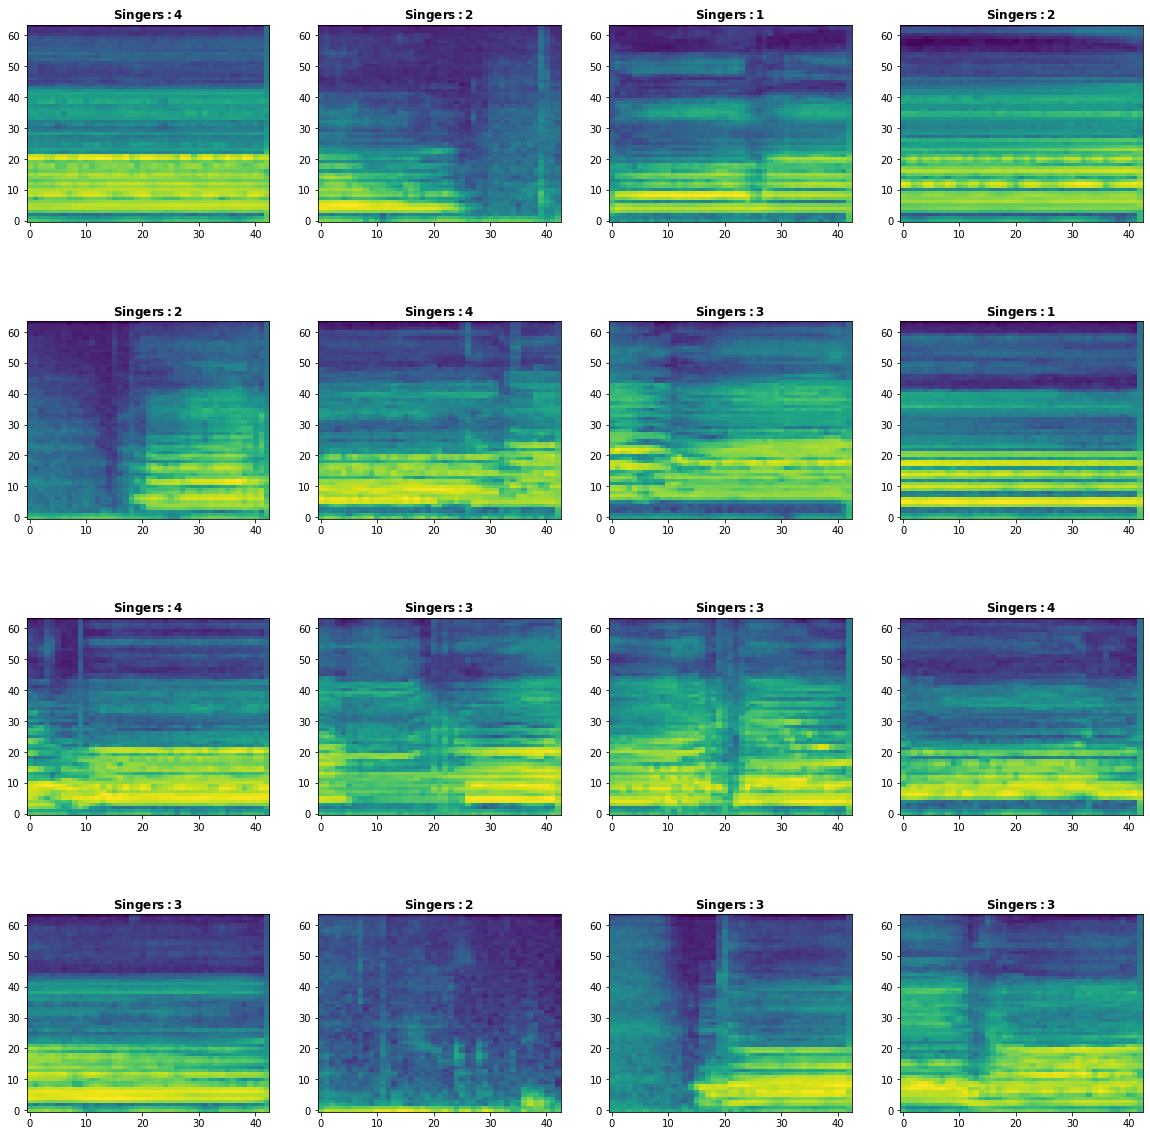

In [19]:
from essentia.standard import *

print('Computing MFCS for training set:')
X_train = createDataForPartition(audio_data_train)
print('Computing MFCS for valid set:')
X_valid = createDataForPartition(audio_data_valid)
print('Computing MFCS for test set:')
X_test  = createDataForPartition(audio_data_test)

plt.figure(1, figsize=(100,100))
plt.subplots(4,4,figsize=(20,20))
plt.subplots_adjust(hspace=0.5)

for i in range(16):
    
    rand_snippet = random.randint(0,np.shape(X_train)[0]-1) # Pick random snippet from audio_data
    mfcc = X_train[rand_snippet].T
    num_singer = int(y_train[rand_snippet])

    plt.subplot(4, 4, (i+1))
    plt.imshow(mfcc, aspect='auto', origin='lower', interpolation='none')
    plt.title(r"$\bf{""Singers: "+str(num_singer)+ "}$")

<a id='part23'></a>
***
### 3. Data Formatting

In [20]:
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

X_train = np.mean(X_train,axis=1)
X_valid = np.mean(X_valid,axis=1)
X_test = np.mean(X_test,axis=1)

onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_valid_onehot = onehot_encoder.fit_transform(y_valid.reshape(len(y_valid), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))

# Finally, we end up with these shapes:
print('Data for Training with Shape:\n'+ str(np.shape(X_train)))
print('Ground Truth for Training Loaded with Shape:\n'+ str(np.shape(y_train_onehot)))
print('Data for Training with Shape:\n'+ str(np.shape(X_valid)))
print('Ground Truth for Training Loaded with Shape:\n'+ str(np.shape(y_valid_onehot)))
print('Data for Testing with Shape:\n'+ str(np.shape(X_test)))
print('Ground Truth for Testing Loaded with Shape:\n'+ str(np.shape(y_test_onehot)))

Data for Training with Shape:
(8192, 64)
Ground Truth for Training Loaded with Shape:
(8192, 4)
Data for Training with Shape:
(2457, 64)
Ground Truth for Training Loaded with Shape:
(2457, 4)
Data for Testing with Shape:
(256, 64)
Ground Truth for Testing Loaded with Shape:
(256, 4)


<a id='part24'></a>
***
### 4. Model Training / Testing

In [24]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    
    # 3. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_3', units = 60))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))


    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train.shape[1])

In [25]:
from sklearn.metrics import classification_report

model.summary()
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train, 
                    y_train_onehot, 
                    batch_size = 25, 
                    epochs = 100,
                    validation_data=(X_valid,y_valid_onehot), 
                    verbose=1)

score = model.evaluate(X_test, y_test_onehot, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 64)                256       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 20)                1300      
_________________________________________________________________
batch_normalization_7 (Batch (None, 20)                80        
_________________________________________________________________
activation_9 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 40)                840       
_________________________________________________________________
batch_normalization_8 (Batch (None, 40)               

8192/8192 [==============================] - 1s 74us/step - loss: 0.7270 - accuracy: 0.6721 - val_loss: 1.6373 - val_accuracy: 0.3032
Epoch 42/100
8192/8192 [==============================] - 1s 76us/step - loss: 0.7273 - accuracy: 0.6713 - val_loss: 1.5370 - val_accuracy: 0.3431
Epoch 43/100
8192/8192 [==============================] - 1s 74us/step - loss: 0.7267 - accuracy: 0.6737 - val_loss: 1.6258 - val_accuracy: 0.3150
Epoch 44/100
8192/8192 [==============================] - 1s 73us/step - loss: 0.7376 - accuracy: 0.6633 - val_loss: 1.6641 - val_accuracy: 0.3114
Epoch 45/100
8192/8192 [==============================] - 1s 73us/step - loss: 0.7297 - accuracy: 0.6696 - val_loss: 1.5715 - val_accuracy: 0.3146
Epoch 46/100
8192/8192 [==============================] - 1s 74us/step - loss: 0.7311 - accuracy: 0.6705 - val_loss: 1.5812 - val_accuracy: 0.3280
Epoch 47/100
8192/8192 [==============================] - 1s 74us/step - loss: 0.7290 - accuracy: 0.6685 - val_loss: 1.6082 - val_a

Epoch 97/100
8192/8192 [==============================] - 1s 72us/step - loss: 0.6751 - accuracy: 0.7007 - val_loss: 1.5293 - val_accuracy: 0.3443
Epoch 98/100
8192/8192 [==============================] - 1s 73us/step - loss: 0.6806 - accuracy: 0.6978 - val_loss: 1.5084 - val_accuracy: 0.3451
Epoch 99/100
8192/8192 [==============================] - 1s 73us/step - loss: 0.6767 - accuracy: 0.7009 - val_loss: 1.7546 - val_accuracy: 0.3146
Epoch 100/100
256/256 [==============================] - 0s 25us/step
Test loss: 1.3745378702878952
Test accuracy: 0.44140625
[1.3745378702878952, 0.44140625]


<a id='part25'></a>
***
### 5. Results

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


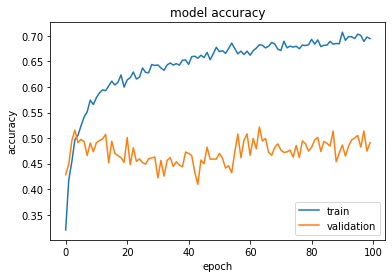

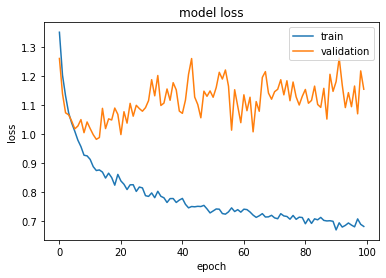

In [23]:
print(summary.history.keys())
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

<a id='part3'></a>
***
<h1><center>Deep Salience Approach</center></h1>

Now that we have computed our baseline, which as you could see left room for great improvement, we can proceed in digging into the core of this experiment: __using a deep salience approach to estimate the number of singing sources__. 

Our experiment will heavily rely on the experiment conducted by Bittner, R et. al tackling the issue of multi-F0 estimation in polyphonic music, using Deep Neural Networks (see: *Deep Salience Representations for F0 Estimation in Polyphonic Music - https://bmcfee.github.io/papers/ismir2017_salience.pdf*).

In fact, we will use the companion code presented in the above-mentioned paper in order to estimate the number of simultaneous singing sources: https://github.com/rabitt/ismir2017-deepsalience

<a id='part31'></a>
***
### 1. Importing Required Python File - Defining Function Parameters

In [36]:
# This file works as a standalone processor (no need for other file dependencies)
import predict_on_audio as ds
from collections import Counter
import librosa
import importlib

ds = importlib.reload(ds)

# Arg Dict passed to the DeepSalience main function
args = {'audio':None,                # audio chunk np array
        'task':'multif0',            # "all, bass, melody1, melody2, melody3, multif0, pitch, vocal."
        'save_dir':'./',             # no used
        'use_neg':True, 
        'threshold':0.03,             # IMPORTANT
        'output_format':'multif0',   # ['singlef0', 'multif0', 'salience']
        'model':None}                # Hold the deep salience model

# Pre-load the keras model into the args dict
args['model'] = ds.load_model(args['task'])

<a id='part32'></a>
***
### 2. Predicting Salience

In [37]:
# Various predicting methodologies for comparison purpose
y_predict_mean   = np.zeros(np.shape(audio_data_test)[0])
y_predict_max    = np.zeros(np.shape(audio_data_test)[0])
y_predict_common = np.zeros(np.shape(audio_data_test)[0])


for idx in notebook.tqdm(range(np.shape(audio_data_test)[0])):
    
    args['audio'] = audio_data_test[idx]
    times, freqs  = ds.main(args)
    # Counting the simultaneous number of singers from the multi_f0 output
    multi_f0 = np.asarray([len(freqs[idx]) for idx in range(len(freqs)) if (len(freqs[idx])>0)])
    
    # If no f0 are found (silent file), fill with dummy value
    if len(multi_f0)==0:
        multi_f0=[0]
    # Computing possible prediction variants (mean, max, most common) 
    y_predict_mean[idx] = np.around(np.mean(multi_f0))
    y_predict_max[idx]  = int(np.max(multi_f0))
    y_predict_common[idx]  = Counter(multi_f0).most_common(1)[0][0]

<a id='part33'></a>
***
### 3. Results

              precision    recall  f1-score   support

    1 Singer       0.74      0.85      0.79        61
    2 Singer       0.58      0.41      0.48        63
    3 Singer       0.30      0.23      0.26        56
    4 Singer       0.62      0.80      0.70        76

   micro avg       0.59      0.59      0.59       256
   macro avg       0.56      0.57      0.56       256
weighted avg       0.57      0.59      0.57       256
 samples avg       0.59      0.59      0.59       256



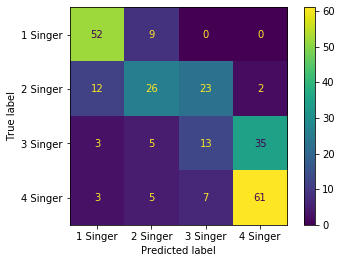

              precision    recall  f1-score   support

    1 Singer       0.71      0.20      0.31        61
    2 Singer       0.22      0.13      0.16        63
    3 Singer       0.00      0.00      0.00        56
    4 Singer       0.43      0.97      0.60        76

   micro avg       0.37      0.37      0.37       256
   macro avg       0.34      0.32      0.27       256
weighted avg       0.35      0.37      0.29       256
 samples avg       0.37      0.37      0.37       256



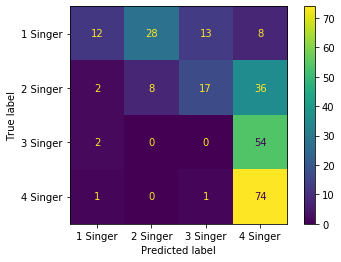

              precision    recall  f1-score   support

    1 Singer       0.64      0.90      0.75        61
    2 Singer       0.68      0.44      0.54        63
    3 Singer       0.44      0.34      0.38        56
    4 Singer       0.66      0.75      0.70        76

   micro avg       0.62      0.62      0.62       256
   macro avg       0.61      0.61      0.59       256
weighted avg       0.61      0.62      0.60       256
 samples avg       0.62      0.62      0.62       256



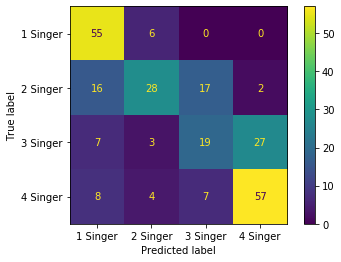

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

predictions = [y_predict_mean,y_predict_max,y_predict_common]
labels      = ['Mean','Max','Most Common']

for (y_predict,title) in zip(predictions,labels):

    # Make sure predictions are within bounds (1-4 singers)
    y_predict[y_predict < 1] = 1
    y_predict[y_predict > 4] = 4
    
    # Convert predictiosn to one-hot
    onehot_encoder = OneHotEncoder(sparse=False)
    y_predict_onehot = onehot_encoder.fit_transform(y_predict.reshape(len(y_predict), 1))
    
    # Print claissification report
    target_names = ['1 Singer', '2 Singer', '3 Singer', '4 Singer']
    print(classification_report(y_test_onehot, y_predict_onehot, target_names=target_names))
    
    # Finally print confusion matrix
    cm   = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal', values_format=None, ax=None)
    
    plt.show()